# RLC Circuit Analysis using Modified Nodal Analysis (MNA)

This notebook allows you to analyze RLC circuits by inputting component values and visualizing the MNA matrix and results.

## Understanding the Series RLC Circuit

A **Series RLC Circuit** consists of a Resistor ($R$), Inductor ($L$), and Capacitor ($C$) connected in a single loop. This circuit is fundamental in electronics because it exhibits **resonance**—a specific frequency where the inductive and capacitive effects cancel each other out.

### What is this circuit doing?
In this configuration (Output taken across the Capacitor $C$), this circuit acts as a **2nd Order Low-Pass Filter**.

* **Low Frequencies:** The capacitor acts like an open circuit (high impedance), so most of the input voltage appears across it. The signal "Passes" through to the output.
* **High Frequencies:** The inductor acts like an open circuit (blocking current), and the capacitor acts like a short circuit. The output voltage drops to near zero. The signal is "Filtered" out.
* **Resonance:** At the specific resonant frequency ($f_0$), the circuit can amplify the voltage significantly if the resistance is low.

### Key Formulas
* **Resonant Frequency ($f_0$):** The frequency where the system vibrates naturally.
    $$f_0 = \frac{1}{2\pi\sqrt{LC}}$$
* **Damping Factor ($\zeta$):** Controlled by Resistance. Determines if the output oscillates (rings) or settles smoothly.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets
from IPython.display import display, Markdown

# Prettier plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## MNA Matrix Builder for RLC Circuits

### Circuit Topology: Series RLC Circuit
```
Vs ---[R]---[L]---[C]--- GND
```

Where:
- Node 0: Ground (reference)
- Node 1: After voltage source
- Node 2: After resistor
- Node 3: After inductor

The MNA formulation for this circuit in frequency domain (s-domain) is:

$$
\begin{bmatrix}
G & A^T \\
A & 0
\end{bmatrix}
\begin{bmatrix}
V \\
I
\end{bmatrix}
=
\begin{bmatrix}
i \\
e
\end{bmatrix}
$$

In [8]:
class RLCCircuitMNA:
    def __init__(self, R, L, C, V_source, frequency=0):
        """
        Initialize RLC circuit with component values.
        """
        self.R = R
        self.L = L
        self.C = C
        self.V_source = V_source
        self.frequency = frequency
        self.omega = 2 * np.pi * frequency
        self.s = 1j * self.omega
        
        # --- FIX: Handle DC (freq=0) with limit values ---
        if frequency == 0:
            # At DC:
            # Inductor is a short circuit -> Resistance approx 0
            self.Z_L = 1e-9  
            # Capacitor is an open circuit -> Resistance approx infinity
            self.Z_C = 1e12  
        else:
            # AC Impedances
            self.Z_L = self.s * L
            self.Z_C = 1 / (self.s * C)
        
    def build_mna_matrix(self):
        """
        Build MNA matrix for series RLC circuit.
        """
        n_nodes = 3
        n_vsources = 1
        n = n_nodes + n_vsources
        
        A = np.zeros((n, n), dtype=complex)
        b = np.zeros(n, dtype=complex)
        
        # Node 1: Voltage source connection
        # KCL: I_vs - I_R = 0 => I_vs - (V1 - V2)/R = 0
        A[0, 0] = 1/self.R
        A[0, 1] = -1/self.R
        A[0, 3] = 1
        b[0] = 0
        
        # Node 2: Between R and L
        # KCL: I_R - I_L = 0 => (V2 - V1)/R + (V2 - V3)/Z_L = 0
        # --- FIX: Removed 'if frequency > 0' check ---
        # We now rely on the limit values set in __init__
        A[1, 0] = -1/self.R
        A[1, 1] = 1/self.R + 1/self.Z_L
        A[1, 2] = -1/self.Z_L
        b[1] = 0
        
        # Node 3: Between L and C
        # KCL: I_L - I_C = 0 => (V3 - V2)/Z_L + V3/Z_C = 0
        # --- FIX: Removed 'if frequency > 0' check ---
        A[2, 1] = -1/self.Z_L
        A[2, 2] = 1/self.Z_L + 1/self.Z_C
        b[2] = 0
        
        # Voltage source constraint: V1 = V_source
        A[3, 0] = 1
        A[3, 3] = 0
        b[3] = self.V_source
        
        return A, b
    
    def solve(self):
        A, b = self.build_mna_matrix()
        x = np.linalg.solve(A, b)
        return x, A, b
    
    def print_results(self, x):
        print("="*60)
        print("CIRCUIT ANALYSIS RESULTS")
        print("="*60)
        print(f"\nCircuit Parameters:")
        print(f"  R = {self.R} Ω")
        print(f"  L = {self.L} H")
        print(f"  C = {self.C} F")
        print(f"  V_source = {self.V_source} V")
        print(f"  Frequency = {self.frequency} Hz")
        
        # Print Impedances (show used values)
        print(f"\nImpedances Used:")
        # Display large/small numbers neatly
        if abs(self.Z_L) < 1e-6:
            print(f"  Z_L ≈ 0 Ω (Short)")
        else:
            print(f"  Z_L = {self.Z_L:.4f} Ω")
            
        if abs(self.Z_C) > 1e6:
            print(f"  Z_C ≈ ∞ Ω (Open)")
        else:
            print(f"  Z_C = {self.Z_C:.4f} Ω")
        
        print(f"\nNode Voltages:")
        for i in range(3):
            if np.abs(x[i].imag) < 1e-10:
                print(f"  V{i+1} = {x[i].real:.6f} V")
            else:
                mag = np.abs(x[i])
                phase = np.angle(x[i], deg=True)
                print(f"  V{i+1} = {mag:.6f} ∠ {phase:.2f}° V")
        
        print(f"\nSource Current:")
        if np.abs(x[3].imag) < 1e-10:
            print(f"  I_vs = {x[3].real:.6f} A")
        else:
            mag = np.abs(x[3])
            phase = np.angle(x[3], deg=True)
            print(f"  I_vs = {mag:.6f} ∠ {phase:.2f}° A")
        
        print("="*60)

# --- Test the Fix ---
R = 100
L = 0.1
C = 1e-6
V_source = 10
frequency = 0  # DC

circuit = RLCCircuitMNA(R, L, C, V_source, frequency)
x, A, b = circuit.solve()

# Use your existing print_matrix function if it's still in the notebook, 
# otherwise you can just use circuit.print_results(x)
circuit.print_results(x)

CIRCUIT ANALYSIS RESULTS

Circuit Parameters:
  R = 100 Ω
  L = 0.1 H
  C = 1e-06 F
  V_source = 10 V
  Frequency = 0 Hz

Impedances Used:
  Z_L ≈ 0 Ω (Short)
  Z_C ≈ ∞ Ω (Open)

Node Voltages:
  V1 = 10.000000 V
  V2 = 10.000010 V
  V3 = 10.000010 V

Source Current:
  I_vs = 0.000000 A


## Example 1: DC Analysis (Frequency = 0 Hz)

At DC, inductors act as short circuits and capacitors as open circuits.

In [9]:
# Example DC analysis
R = 100  # Ohms
L = 0.1  # Henry
C = 1e-6  # Farad (1 µF)
V_source = 10  # Volts
frequency = 0  # DC

circuit = RLCCircuitMNA(R, L, C, V_source, frequency)
x, A, b = circuit.solve()

print_matrix(A, b, "DC MNA Matrix")
circuit.print_results(x)


DC MNA Matrix:

Ax = b

Matrix A:
  [  0.0100   -0.0100    0.0000    1.0000]
  [ -0.0100  1000000000.0100  -1000000000.0000    0.0000]
  [  0.0000  -1000000000.0000  1000000000.0000    0.0000]
  [  1.0000    0.0000    0.0000    0.0000]

Vector b:
  [0.0000]
  [0.0000]
  [0.0000]
  [10.0000]

CIRCUIT ANALYSIS RESULTS

Circuit Parameters:
  R = 100 Ω
  L = 0.1 H
  C = 1e-06 F
  V_source = 10 V
  Frequency = 0 Hz

Impedances Used:
  Z_L ≈ 0 Ω (Short)
  Z_C ≈ ∞ Ω (Open)

Node Voltages:
  V1 = 10.000000 V
  V2 = 10.000010 V
  V3 = 10.000010 V

Source Current:
  I_vs = 0.000000 A


## Example 2: AC Analysis at Specific Frequency

In [10]:
# Example AC analysis
R = 100  # Ohms
L = 0.1  # Henry
C = 1e-6  # Farad (1 µF)
V_source = 10  # Volts
frequency = 159.15  # Hz (close to resonance)

circuit = RLCCircuitMNA(R, L, C, V_source, frequency)
x, A, b = circuit.solve()

print_matrix(A, b, "AC MNA Matrix")
circuit.print_results(x)


AC MNA Matrix:

Ax = b

Matrix A:
  [  0.0100   -0.0100    0.0000    1.0000]
  [ -0.0100    0.0100 -0.0100j    0.0000 +0.0100j    0.0000]
  [  0.0000    0.0000 +0.0100j    0.0000 -0.0090j    0.0000]
  [  1.0000    0.0000    0.0000    0.0000]

Vector b:
  [0.0000]
  [0.0000]
  [0.0000]
  [10.0000]

CIRCUIT ANALYSIS RESULTS

Circuit Parameters:
  R = 100 Ω
  L = 0.1 H
  C = 1e-06 F
  V_source = 10 V
  Frequency = 159.15 Hz

Impedances Used:
  Z_L = 0.0000+99.9969j Ω
  Z_C = 0.0000-1000.0311j Ω

Node Voltages:
  V1 = 10.000000 V
  V2 = 9.938842 ∠ -6.34° V
  V3 = 11.043082 ∠ -6.34° V

Source Current:
  I_vs = 0.011043 ∠ -96.34° A


## Interactive Circuit Analysis

Use the sliders below to change circuit parameters and see the results update in real-time.

In [11]:
# Interactive widget for circuit analysis
def analyze_circuit(R, L, C, V_source, frequency):
    circuit = RLCCircuitMNA(R, L, C, V_source, frequency)
    x, A, b = circuit.solve()
    
    print_matrix(A, b, "MNA System")
    circuit.print_results(x)
    
    # Calculate resonant frequency
    f_resonant = 1 / (2 * np.pi * np.sqrt(L * C))
    print(f"\nResonant Frequency: {f_resonant:.2f} Hz")
    print(f"Quality Factor (Q): {(1/R) * np.sqrt(L/C):.2f}")

# Create interactive widgets
widgets.interact(
    analyze_circuit,
    R=widgets.FloatSlider(value=100, min=1, max=1000, step=10, description='R (Ω):'),
    L=widgets.FloatSlider(value=0.1, min=0.001, max=1, step=0.01, description='L (H):'),
    C=widgets.FloatSlider(value=1e-6, min=1e-9, max=1e-3, step=1e-7, description='C (F):', readout_format='.2e'),
    V_source=widgets.FloatSlider(value=10, min=1, max=100, step=1, description='V (V):'),
    frequency=widgets.FloatSlider(value=159, min=0, max=1000, step=1, description='f (Hz):')
);

interactive(children=(FloatSlider(value=100.0, description='R (Ω):', max=1000.0, min=1.0, step=10.0), FloatSli…

## Frequency Response Analysis

Analyze how the circuit responds across a range of frequencies.

In [12]:
def plot_frequency_response(R, L, C, V_source):
    """
    Plot frequency response (Bode plot) for the RLC circuit.
    """
    frequencies = np.logspace(0, 4, 500)  # 1 Hz to 10 kHz
    
    V_out = []
    I_source = []
    
    for f in frequencies:
        circuit = RLCCircuitMNA(R, L, C, V_source, f)
        x, _, _ = circuit.solve()
        V_out.append(x[2])  # Voltage at node 3 (across capacitor)
        I_source.append(x[3])  # Source current
    
    V_out = np.array(V_out)
    I_source = np.array(I_source)
    
    # Calculate transfer function H(jw) = V_out / V_in
    H = V_out / V_source
    
    # Calculate resonant frequency
    f_resonant = 1 / (2 * np.pi * np.sqrt(L * C))
    
    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    
    # Magnitude plot
    axes[0, 0].semilogx(frequencies, 20 * np.log10(np.abs(H)))
    axes[0, 0].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('Magnitude (dB)')
    axes[0, 0].set_title('Transfer Function Magnitude')
    axes[0, 0].grid(True, which='both', alpha=0.3)
    axes[0, 0].legend()
    
    # Phase plot
    axes[0, 1].semilogx(frequencies, np.angle(H, deg=True))
    axes[0, 1].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Phase (degrees)')
    axes[0, 1].set_title('Transfer Function Phase')
    axes[0, 1].grid(True, which='both', alpha=0.3)
    axes[0, 1].legend()
    
    # Output voltage magnitude
    axes[1, 0].semilogx(frequencies, np.abs(V_out))
    axes[1, 0].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[1, 0].set_xlabel('Frequency (Hz)')
    axes[1, 0].set_ylabel('Voltage (V)')
    axes[1, 0].set_title('Output Voltage Magnitude (V_C)')
    axes[1, 0].grid(True, which='both', alpha=0.3)
    axes[1, 0].legend()
    
    # Current magnitude
    axes[1, 1].semilogx(frequencies, np.abs(I_source) * 1000)  # Convert to mA
    axes[1, 1].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Current (mA)')
    axes[1, 1].set_title('Source Current Magnitude')
    axes[1, 1].grid(True, which='both', alpha=0.3)
    axes[1, 1].legend()
    
    # Impedance magnitude
    Z_total = V_source / I_source
    axes[2, 0].semilogx(frequencies, np.abs(Z_total))
    axes[2, 0].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[2, 0].axhline(R, color='g', linestyle='--', label=f'R = {R} Ω')
    axes[2, 0].set_xlabel('Frequency (Hz)')
    axes[2, 0].set_ylabel('Impedance (Ω)')
    axes[2, 0].set_title('Total Circuit Impedance')
    axes[2, 0].grid(True, which='both', alpha=0.3)
    axes[2, 0].legend()
    
    # Impedance phase
    axes[2, 1].semilogx(frequencies, np.angle(Z_total, deg=True))
    axes[2, 1].axvline(f_resonant, color='r', linestyle='--', label=f'Resonance: {f_resonant:.2f} Hz')
    axes[2, 1].axhline(0, color='g', linestyle='--', label='Resistive')
    axes[2, 1].set_xlabel('Frequency (Hz)')
    axes[2, 1].set_ylabel('Phase (degrees)')
    axes[2, 1].set_title('Impedance Phase')
    axes[2, 1].grid(True, which='both', alpha=0.3)
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCircuit Parameters:")
    print(f"  R = {R} Ω")
    print(f"  L = {L} H")
    print(f"  C = {C} F")
    print(f"  V_source = {V_source} V")
    print(f"\nResonant Frequency: {f_resonant:.2f} Hz")
    print(f"Quality Factor (Q): {(1/R) * np.sqrt(L/C):.2f}")
    print(f"Bandwidth: {f_resonant / ((1/R) * np.sqrt(L/C)):.2f} Hz")

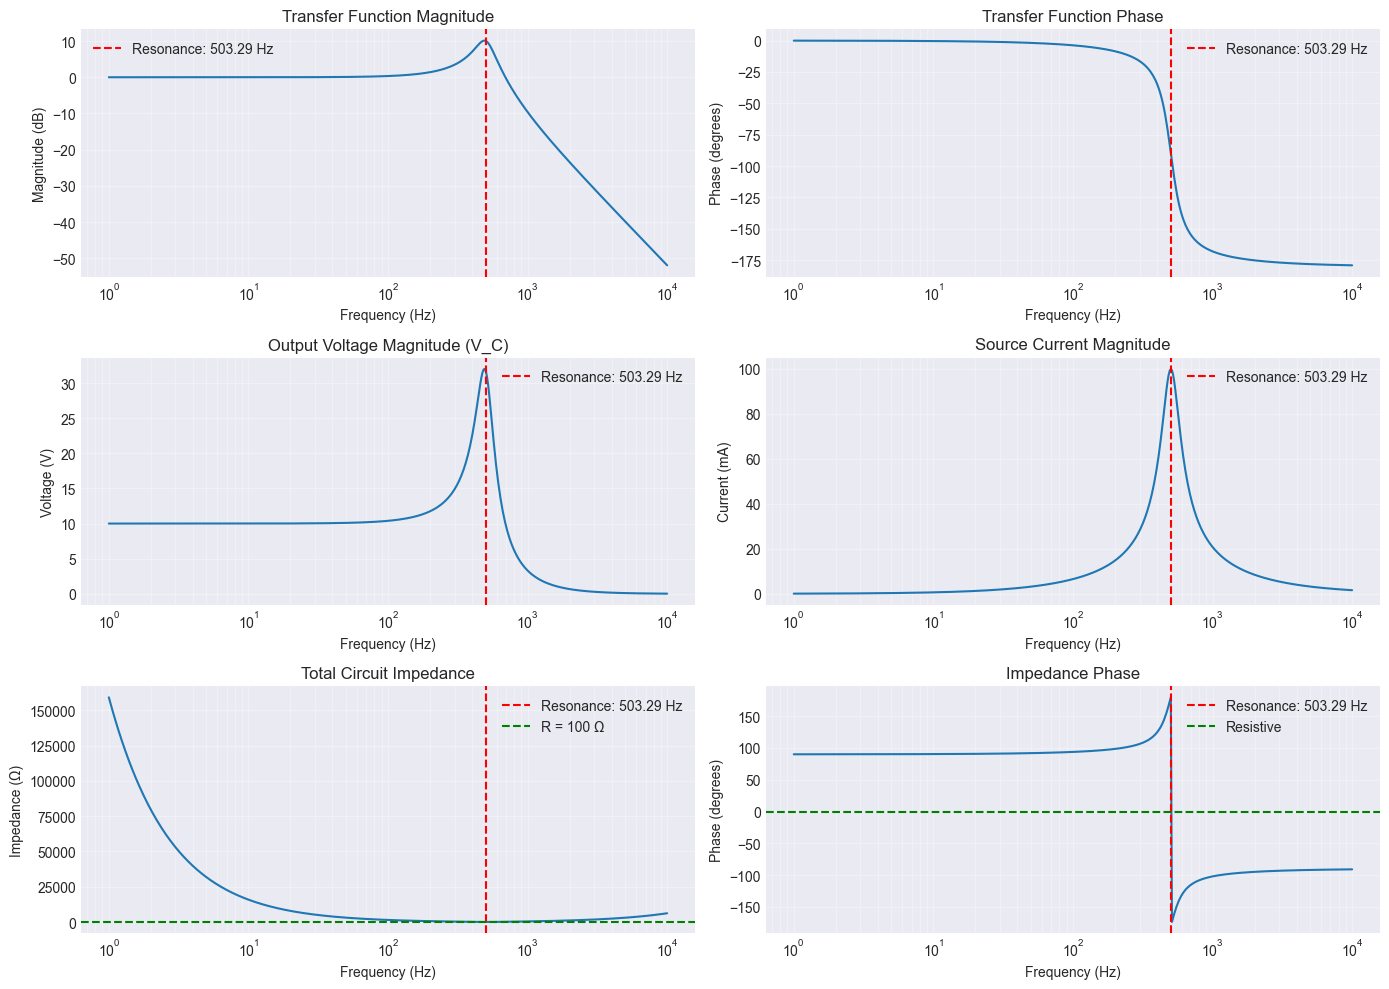


Circuit Parameters:
  R = 100 Ω
  L = 0.1 H
  C = 1e-06 F
  V_source = 10 V

Resonant Frequency: 503.29 Hz
Quality Factor (Q): 3.16
Bandwidth: 159.15 Hz


In [13]:
# Plot frequency response with default values
plot_frequency_response(R=100, L=0.1, C=1e-6, V_source=10)

## Interactive Frequency Response

Adjust the parameters to see how they affect the frequency response.

### Interactive Guide: How Variables Change the Plots

Use the sliders above to see how changing components affects the circuit response.

#### 1. Changing Resistance ($R$) $\rightarrow$ Controls "Damping"
* **Low Resistance ($R \downarrow$):** The circuit becomes **"Underdamped."**
    * **Effect:** You will see a sharp **spike** (resonance peak) in voltage and current near the resonant frequency.
    * **Physics:** There is little friction (resistance) to stop the energy from bouncing back and forth between the inductor and capacitor.
* **High Resistance ($R \uparrow$):** The circuit becomes **"Overdamped."**
    * **Effect:** The peak flattens out completely. The transition from "pass" to "filter" becomes very smooth.
    * **Physics:** The resistor dissipates the energy quickly, preventing ringing/oscillation.

#### 2. Changing Inductance ($L$) & Capacitance ($C$) $\rightarrow$ Controls "Frequency"
* **Increasing $L$ or $C$:**
    * **Effect:** The resonance peak (the red dashed line) moves to the **Left** (Lower Frequency).
    * **Analogy:** A heavier pendulum (more $L$) or a looser spring (more $C$) swings slower.
* **Decreasing $L$ or $C$:**
    * **Effect:** The resonance peak moves to the **Right** (Higher Frequency).
    * **Analogy:** A lighter mass or stiffer spring vibrates faster.

#### Summary of Graphs
| Graph | What to look for |
| :--- | :--- |
| **Transfer Function (Mag)** | **Flat line** at low freq (Pass), **Slope down** at high freq (Stop). Look for the "hump" at the red line. |
| **Source Current** | Shows a **peak** at resonance. This is where impedance is lowest ($Z_{total} \approx R$). |
| **Impedance Phase** | Switches from **-90°** (Capacitive) to **+90°** (Inductive). Crosses **0°** exactly at resonance. |

In [ ]:
# Interactive frequency response widget
widgets.interact(
    plot_frequency_response,
    R=widgets.FloatSlider(value=100, min=10, max=1000, step=10, description='R (Ω):'),
    L=widgets.FloatSlider(value=0.1, min=0.001, max=1, step=0.01, description='L (H):'),
    C=widgets.FloatSlider(value=1e-6, min=1e-9, max=1e-4, step=1e-7, description='C (F):', readout_format='.2e'),
    V_source=widgets.fixed(10)
);

interactive(children=(FloatSlider(value=100.0, description='R (Ω):', max=1000.0, min=10.0, step=10.0), FloatSl…

## Custom Circuit Analysis

Enter your own values below to analyze a custom RLC circuit.

Enter your circuit parameters:

Custom Circuit MNA Matrix:

Ax = b

Matrix A:
  [  0.0200   -0.0200    0.0000    1.0000]
  [ -0.0200    0.0200 -0.0318j    0.0000 +0.0318j    0.0000]
  [  0.0000    0.0000 +0.0318j    0.0000 -0.0255j    0.0000]
  [  1.0000    0.0000    0.0000    0.0000]

Vector b:
  [0.0000]
  [0.0000]
  [0.0000]
  [5.0000]

CIRCUIT ANALYSIS RESULTS

Circuit Parameters:
  R = 50 Ω
  L = 0.05 H
  C = 1e-05 F
  V_source = 5 V
  Frequency = 100 Hz

Impedances Used:
  Z_L = 0.0000+31.4159j Ω
  Z_C = 0.0000-159.1549j Ω

Node Voltages:
  V1 = 5.000000 V
  V2 = 4.656026 ∠ -21.38° V
  V3 = 5.801122 ∠ -21.38° V

Source Current:
  I_vs = 0.036450 ∠ -111.38° A


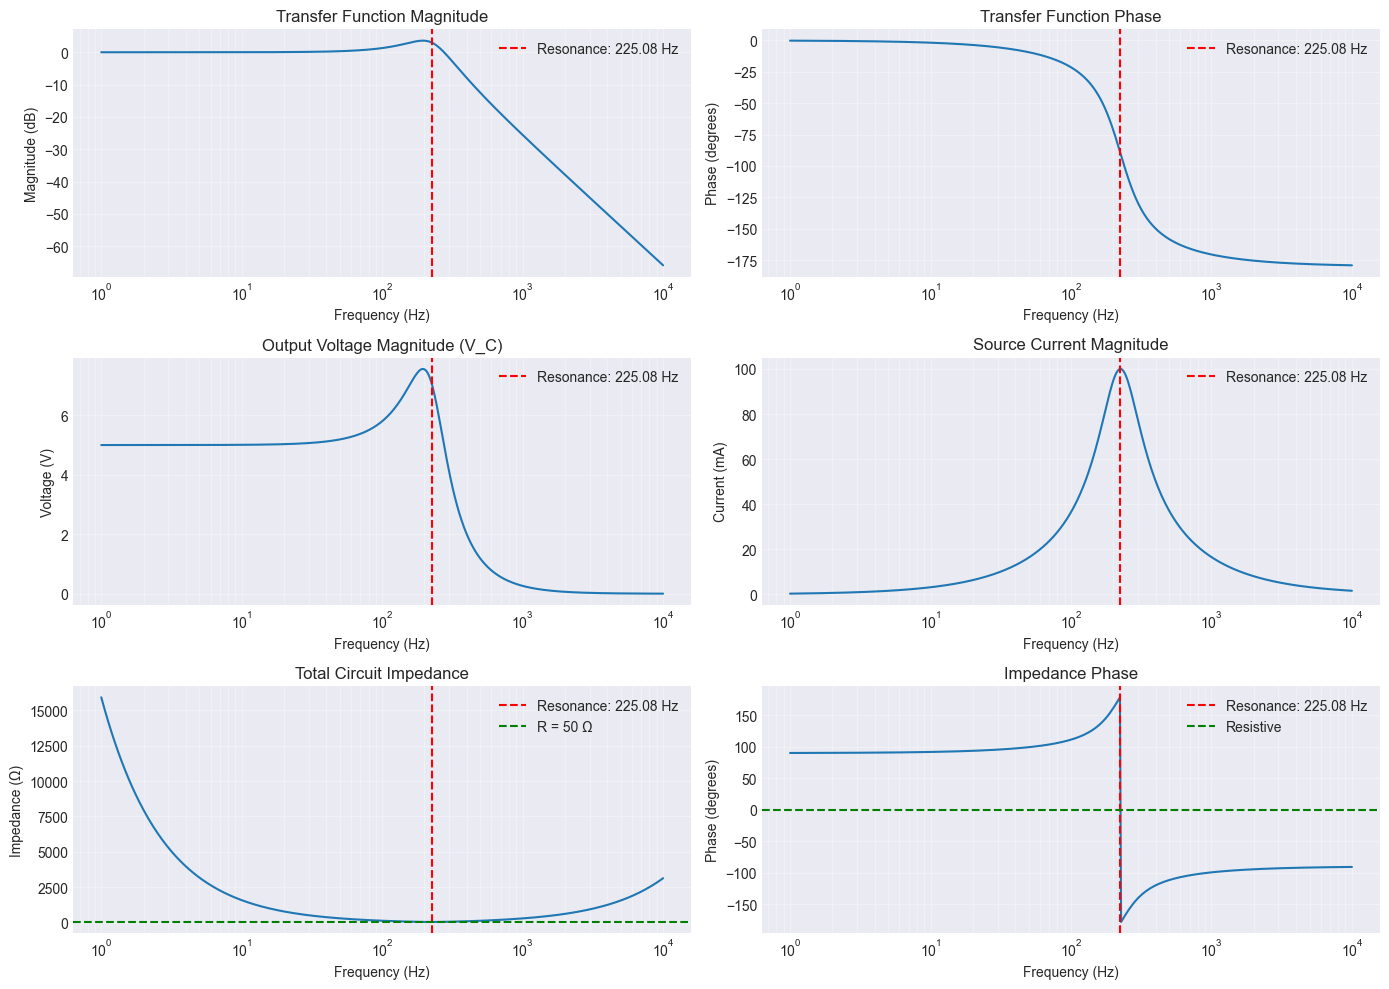


Circuit Parameters:
  R = 50 Ω
  L = 0.05 H
  C = 1e-05 F
  V_source = 5 V

Resonant Frequency: 225.08 Hz
Quality Factor (Q): 1.41
Bandwidth: 159.15 Hz


In [15]:
# Custom input section
print("Enter your circuit parameters:")
print("=" * 60)

# You can modify these values and re-run the cell
R_custom = 50  # Ohms
L_custom = 0.05  # Henry
C_custom = 10e-6  # Farad
V_custom = 5  # Volts
f_custom = 100  # Hz

circuit_custom = RLCCircuitMNA(R_custom, L_custom, C_custom, V_custom, f_custom)
x_custom, A_custom, b_custom = circuit_custom.solve()

print_matrix(A_custom, b_custom, "Custom Circuit MNA Matrix")
circuit_custom.print_results(x_custom)

# Also plot frequency response
plot_frequency_response(R_custom, L_custom, C_custom, V_custom)

## Validation: Compare with Theoretical Calculations

Verify the MNA results against theoretical formulas for series RLC circuits.

In [16]:
def validate_results(R, L, C, V_source, frequency):
    """
    Compare MNA results with theoretical calculations.
    """
    # MNA solution
    circuit = RLCCircuitMNA(R, L, C, V_source, frequency)
    x, A, b = circuit.solve()
    
    # Theoretical calculation
    omega = 2 * np.pi * frequency
    s = 1j * omega
    
    if frequency > 0:
        Z_L = s * L
        Z_C = 1 / (s * C)
        Z_total_theory = R + Z_L + Z_C
        I_theory = V_source / Z_total_theory
        
        V_R_theory = I_theory * R
        V_L_theory = I_theory * Z_L
        V_C_theory = I_theory * Z_C
    else:
        Z_total_theory = R
        I_theory = 0  # DC with capacitor = open circuit
        V_R_theory = 0
        V_L_theory = 0
        V_C_theory = 0
    
    print("="*80)
    print("VALIDATION: MNA vs Theoretical")
    print("="*80)
    
    print(f"\nSource Current:")
    print(f"  MNA:        {np.abs(x[3]):.6f} A ∠ {np.angle(x[3], deg=True):.2f}°")
    print(f"  Theory:     {np.abs(I_theory):.6f} A ∠ {np.angle(I_theory, deg=True):.2f}°")
    print(f"  Error:      {np.abs(np.abs(x[3]) - np.abs(I_theory)):.2e} A")
    
    if frequency > 0:
        # Calculate voltages from MNA
        V_R_mna = x[0] - x[1]
        V_L_mna = x[1] - x[2]
        V_C_mna = x[2]
        
        print(f"\nVoltage across R:")
        print(f"  MNA:        {np.abs(V_R_mna):.6f} V ∠ {np.angle(V_R_mna, deg=True):.2f}°")
        print(f"  Theory:     {np.abs(V_R_theory):.6f} V ∠ {np.angle(V_R_theory, deg=True):.2f}°")
        print(f"  Error:      {np.abs(np.abs(V_R_mna) - np.abs(V_R_theory)):.2e} V")
        
        print(f"\nVoltage across L:")
        print(f"  MNA:        {np.abs(V_L_mna):.6f} V ∠ {np.angle(V_L_mna, deg=True):.2f}°")
        print(f"  Theory:     {np.abs(V_L_theory):.6f} V ∠ {np.angle(V_L_theory, deg=True):.2f}°")
        print(f"  Error:      {np.abs(np.abs(V_L_mna) - np.abs(V_L_theory)):.2e} V")
        
        print(f"\nVoltage across C:")
        print(f"  MNA:        {np.abs(V_C_mna):.6f} V ∠ {np.angle(V_C_mna, deg=True):.2f}°")
        print(f"  Theory:     {np.abs(V_C_theory):.6f} V ∠ {np.angle(V_C_theory, deg=True):.2f}°")
        print(f"  Error:      {np.abs(np.abs(V_C_mna) - np.abs(V_C_theory)):.2e} V")
        
        # Verify KVL
        sum_voltages = V_R_mna + V_L_mna + V_C_mna
        print(f"\nKVL Check (V_R + V_L + V_C should equal V_source):")
        print(f"  Sum:        {np.abs(sum_voltages):.6f} V ∠ {np.angle(sum_voltages, deg=True):.2f}°")
        print(f"  V_source:   {V_source:.6f} V")
        print(f"  Error:      {np.abs(np.abs(sum_voltages) - V_source):.2e} V")
    
    print("="*80)

# Run validation
validate_results(R=100, L=0.1, C=1e-6, V_source=10, frequency=159.15)

VALIDATION: MNA vs Theoretical

Source Current:
  MNA:        0.011043 A ∠ -96.34°
  Theory:     0.011043 A ∠ 83.66°
  Error:      5.20e-18 A

Voltage across R:
  MNA:        1.104274 V ∠ 83.66°
  Theory:     1.104274 V ∠ 83.66°
  Error:      1.33e-15 V

Voltage across L:
  MNA:        1.104240 V ∠ 173.66°
  Theory:     1.104240 V ∠ 173.66°
  Error:      2.00e-15 V

Voltage across C:
  MNA:        11.043082 V ∠ -6.34°
  Theory:     11.043082 V ∠ -6.34°
  Error:      1.78e-15 V

KVL Check (V_R + V_L + V_C should equal V_source):
  Sum:        10.000000 V ∠ 0.00°
  V_source:   10.000000 V
  Error:      0.00e+00 V


## Notes and Observations

1. **At Resonance**: When $f = f_0 = \frac{1}{2\pi\sqrt{LC}}$, the inductive and capacitive reactances cancel, leaving only resistance.

2. **Quality Factor**: $Q = \frac{1}{R}\sqrt{\frac{L}{C}}$ determines the sharpness of the resonance peak.

3. **Phase Relationships**: 
   - Below resonance: Circuit is capacitive (current leads voltage)
   - At resonance: Circuit is resistive (current and voltage in phase)
   - Above resonance: Circuit is inductive (current lags voltage)

4. **MNA Validation**: The MNA results should match theoretical calculations within numerical precision (typically < 1e-10).